Import 


In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import poppy.zernike as zernike
import re
import os
import copy

from scipy.ndimage import gaussian_filter
from scipy.optimize import curve_fit
from numpy import pi
from gs_engine import GerSaxPhaseRetriever, mm, nm 


# Pre-processing   

Foundamental passage to use GS class

1. Get ".tiff" images 
2. Selection of ROI and BG for each of the input function
3. Setting number of pixel for the 2 dimension

TYPES
{1: <class 'int'>, 1e-05: <class 'float'>, '1': <class 'str'>, 1j: <class 'complex'>}

STRUCTURED TYPES

-Tuples
	(0, '0', 1j)	(0, '0', 1j)	FINITE, ORDERED, IMMUTABLE	|O_O|
-Lists
   [[0, '0'], [1, '1'], [2, '2'], [3, '3']]   [[0, '0'], [1, '1'], [2, '2']]   ORDERED, MUTABLE	U_U

     Accessing elements of a list/tuple
	slicing:[[0, '0'], [1, '1']], single element:[3, '3']

-Dictionaries
  {0: '0', 1: '1', 2: '2', 3: '3'}  {'0': 0, '1': 1, '2': 'Hello World!', '3': 'Hello World!'}  {0: '0', '1': 1, (1.4142135623730951+1.4142135623730951j): 2.0}
key-value PAIR, ORDERED, MUTABLE	^_^
A very important, not-built-in , structured type: <class 'numpy.ndarray'>
[['0' '0']
 ['1' '1']
 ['2' '2']
 ['3' '3']]
column:['0' '1' '2' '3'](0-axis), row:['0' '0'](1-axis), element:2
>>	AuxiliaryClass successfully created
>>	OK! Directory exists
>>	OK, file 298cm.tiff exists
>>	OK, file 303cm.tiff exists
>>	OK, file 308cm.tiff exists
>>	OK, file 313cm.tiff exists
>>	OK, file 318cm.tiff exists
>>	OK, 

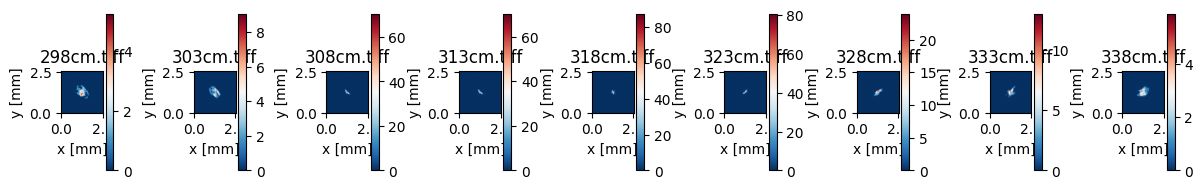

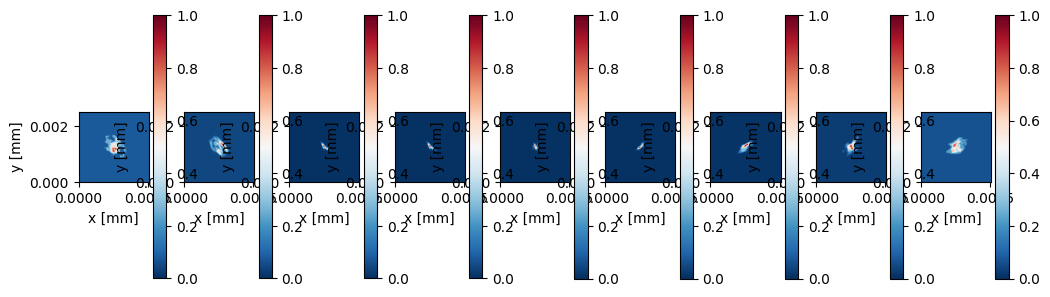

Caricate 9 immagini.
Prima immagine: 298cm.tiff


In [4]:
InputDIR = "./imgs_folder/te_22_05_cannone/"
wavelength =633*nm
# Eseguiamo il tuo notebook esistente.
# Tutte le variabili create lì (specialmente 'inputImages') diventano disponibili qui.
%run "PreProcessing.ipynb"

# Verifica rapida che tutto sia caricato
print(f"Caricate {len(inputImages)} immagini.")
print(f"Prima immagine: {inputImages[0].imageName}")

# GS Reconstruction

Ordinate the files in the correct order (highest to lowest in our setup) and automatically calculate relative distances. Set to zero negative values, to prevent the algorithm divergence if encounter a NaN form sqrt of a negative number.

In [5]:

def estrai_distanza_da_obj(img_obj):
    # img_obj.imageName contiene il nome del file
    match = re.search(r'(\d+)', os.path.basename(img_obj.imageName))
    return int(match.group(1)) if match else 0

valori_grezzi = np.array([estrai_distanza_da_obj(img) for img in inputImages])

# Otteniamo gli indici per ordinare dal più grande al più piccolo (425 -> 225)
ordine_calcolato = np.argsort(valori_grezzi)[::-1]
valori_ordinati = valori_grezzi[ordine_calcolato]

print(f"Ordine indici: {ordine_calcolato}")
print(f"Valori grezzi ordinati: {valori_ordinati}")

correction = 0.1 

delta_raw = np.abs(np.diff(valori_ordinati))
d = (delta_raw *0.1) * mm

print(f"Distanze calcolate (m): {d}")

# --- 3. Report di Propagazione ---
print("\n--- REPORT SEQUENZA ---")
for i, idx in enumerate(ordine_calcolato):
    nome_f = os.path.basename(inputImages[idx].imageName)
    
    if i < len(d):
        step_m = d[i]
        print(f"[{i+1}] {nome_f} \n    |  ↓  Propagazione: {step_m*1000:.1f} mm ({step_m:.4f} m)")
    else:
        print(f"[{i+1}] {nome_f} (Piano Finale / Far Field)")
    
print("--- PULIZIA IMMAGINI ---")
for i, img in enumerate(inputImages):
    # Controlliamo il minimo prima
    min_val = np.min(img.centeredROI)
    print(f"Img {i}: Minimo originale = {min_val:.4f}")
    
    # FORZIAMO A ZERO I VALORI NEGATIVI
    img.centeredROI = np.maximum(img.centeredROI, 0)
    
    # Verifica
    print(f"Img {i}: Minimo post-pulizia = {np.min(img.centeredROI):.4f}")

print("\nImmagini sanitizzate. Ora i NaN dovrebbero sparire.")

Ordine indici: [8 7 6 5 4 3 2 1 0]
Valori grezzi ordinati: [338 333 328 323 318 313 308 303 298]
Distanze calcolate (m): [0.0005 0.0005 0.0005 0.0005 0.0005 0.0005 0.0005 0.0005]

--- REPORT SEQUENZA ---
[1] 338cm.tiff 
    |  ↓  Propagazione: 0.5 mm (0.0005 m)
[2] 333cm.tiff 
    |  ↓  Propagazione: 0.5 mm (0.0005 m)
[3] 328cm.tiff 
    |  ↓  Propagazione: 0.5 mm (0.0005 m)
[4] 323cm.tiff 
    |  ↓  Propagazione: 0.5 mm (0.0005 m)
[5] 318cm.tiff 
    |  ↓  Propagazione: 0.5 mm (0.0005 m)
[6] 313cm.tiff 
    |  ↓  Propagazione: 0.5 mm (0.0005 m)
[7] 308cm.tiff 
    |  ↓  Propagazione: 0.5 mm (0.0005 m)
[8] 303cm.tiff 
    |  ↓  Propagazione: 0.5 mm (0.0005 m)
[9] 298cm.tiff (Piano Finale / Far Field)
--- PULIZIA IMMAGINI ---
Img 0: Minimo originale = -0.4443
Img 0: Minimo post-pulizia = 0.0000
Img 1: Minimo originale = -0.4455
Img 1: Minimo post-pulizia = 0.0000
Img 2: Minimo originale = -0.4034
Img 2: Minimo post-pulizia = 0.0000
Img 3: Minimo originale = -0.4027
Img 3: Minimo post-pu

In [6]:
GS = GerSaxPhaseRetriever(*inputImages,
                          distances=d,
                          wavelength=wavelength, ordering=ordine_calcolato)

print("Avvio algoritmo GS...")
GS.GS_algorithm(Niterations=1000)

Avvio algoritmo GS...


In [7]:
# Verifica integrità dati
campo = GS.FarField.field
ci_sono_nan = np.isnan(campo).any()
ci_sono_inf = np.isinf(campo).any()
max_val = np.max(np.abs(campo))

print(f"--- DIAGNOSTICA ---")
print(f"Ci sono NaN? {ci_sono_nan}")     # Se TRUE -> L'algoritmo diverge
print(f"Ci sono Inf? {ci_sono_inf}")     # Se TRUE -> Divisione per zero
print(f"Intensità Max: {max_val:.4e}")   # Se è 0.0 -> Il campo è vuoto
print(f"-------------------")

--- DIAGNOSTICA ---
Ci sono NaN? False
Ci sono Inf? False
Intensità Max: 4.1749e+00
-------------------


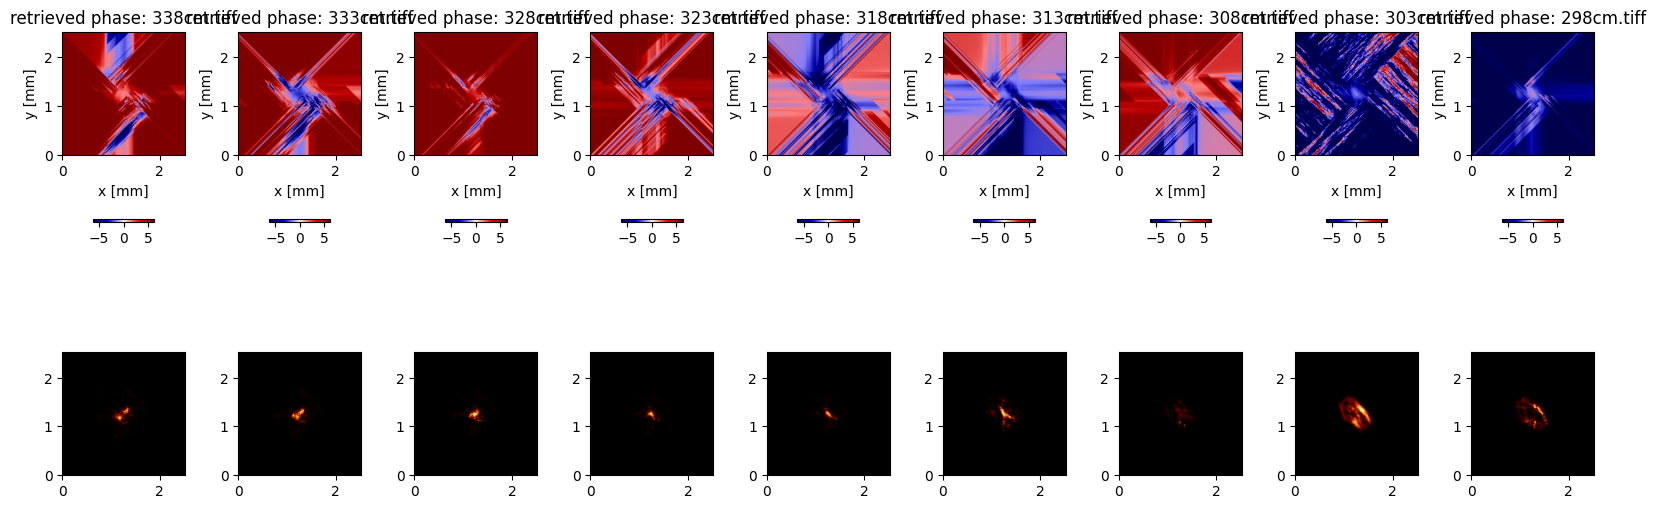

In [8]:
ax_titles = [f"retrieved phase: {name}" for name in GS.imagesNames]
ax_titles_copy = [f"retrieved intensity: {name}" for name in GS.imagesNames]
fig,ax = plt.subplot_mosaic([ax_titles,ax_titles_copy],figsize=(16,8))
extent = np.array([0,GS.size,0,GS.size])*1e3
for i,name in enumerate(GS.imagesNames):
    foo = ax[ax_titles_copy[i]].imshow(GS.RetrieveIntensity(name),cmap='afmhot',vmin=0,extent=extent)
    is_img=ax[ax_titles[i]].imshow(GS.RetrievePhase(name,unwrap=True),cmap='seismic',vmax=2*pi,vmin=-2*pi,extent=extent)
    fig.colorbar(is_img,shrink=.5,location='bottom')
    ax[ax_titles[i]].set_title(ax_titles[i])
    ax[ax_titles[i]].set_xlabel('x [mm]')
    ax[ax_titles[i]].set_ylabel('y [mm]')
fig.tight_layout()

# Algorithm Results

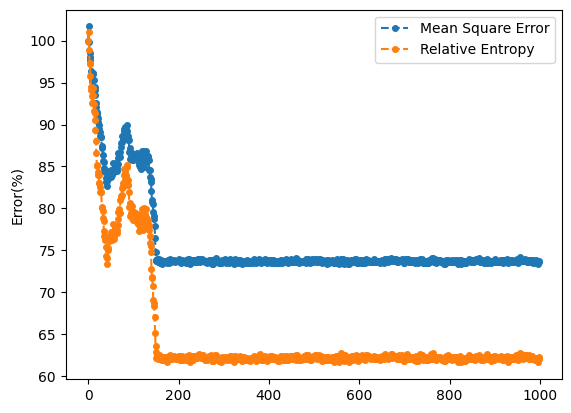

In [9]:
fig,ax = plt.subplots(1,1)
ax.plot(GS.MSError[1:]/GS.MSError[1]*100,'o--',ms=4,label='Mean Square Error')
ax.plot(GS.CEError[1:]/GS.CEError[1]*100,'o--',ms=4,label='Relative Entropy')
ax.set_ylabel('Error(%)')
ax.legend()

# Super-Gaussian Fit

We want to fit the intensity images using a Super-Gaussian function to define the iris in which we will apply the Zernike fitting. The super-gaussian function used is the following:
\begin{equation}
 I(x)=A*exp{\big[  -2*(\frac{r}{w})^P\big]}
\end{equation}
where P=1,2 means respectively a Gaussian and the Super-Gaussian.

* Data prep

In [10]:
# Normalize and create different Grid of different size
normalized_input_intensity = []
Y = []
X = []
for i, name in enumerate(GS.imagesNames):
    I_data = GS.RetrieveIntensity(name)
    I_data = I_data / np.max(I_data) 
    normalized_input_intensity.append(I_data)
    h, w_img = I_data.shape
    temp_y, temp_x = np.mgrid[0:h, 0:w_img]
    Y.append(temp_y)
    X.append(temp_x)

print(f"Dati pronti. Caricate {len(normalized_input_intensity)} matrici")
#Model definition

def super_gaussian_curve(coords, A, x0,y0, w, P, offset):
    y,x = coords
    r=np.sqrt((x-x0)**2+ (y-y0)**2)
    g=A* np.exp(-2*(r/w)**P) + offset
    return g.ravel()
    

Dati pronti. Caricate 9 matrici


* Intensity reconstruction

To prevent a noisy pixel to become the centre causing the crash of the Fit we apply a gaussian Filter. Instead to make a more accurate waist guess we create a dynamic guessing.

In [18]:
fit_intensity = []# Eventually could contain I_model and residual for future application

#cycling over intensity
for I_norm, grid_y, grid_x, name in zip(normalized_input_intensity, Y, X, GS.imagesNames):
    # SMOOTHING
    I_smooth = gaussian_filter(I_norm, sigma=3)
    y_max, x_max = np.unravel_index(np.argmax(I_smooth), I_norm.shape)
    
    # DYNAMIC WAIST GUESS
    # Count pixel over 50% of intensity
    area_pixel = np.sum(I_norm > 0.10)
    w_guess = np.sqrt(area_pixel / np.pi)
    
    #It prevents error on empty images
    w_guess = max(w_guess, 5.0)
    #find maximum to center fit, to find this maximum we extract the index from a 1D array (created by np.argmax, from a 2D matrix)
    # then we use np.unravel_index get this enormous index and convert it to the position in the  2D array
    y_max, x_max=np.unravel_index(np.argmax(I_norm), I_norm.shape)
    #Initial Guess
    p0=[1.0, x_max, y_max, w_guess, 2.0, 0.0]
    #we don't want a negative waist w<0 and a too peaked gaussian P<1
    bounds=([0.5, 0, 0, 1.0, 1.0, 0], [1.5, grid_x.shape[1], grid_x.shape[0], grid_x.shape[1]/2, 20.0, 0.5])
    try: #Execute fitting, the algorythm used is named Levenberg-Marquardt
        popt, pcov = curve_fit(super_gaussian_curve, (grid_y, grid_x), I_norm.ravel(), p0=p0, bounds=bounds)
        
        A, x0, y0, w_fit, P_fit, offset = popt
        # Print results
        print(f"{name:<20} | {w_fit:.2f}       | {P_fit:.4f}     | ({x0:.1f}, {y0:.1f})")
        
        # Save data to easily get it later 
        fit_intensity.append({
            'Name': name,
            'Waist': w_fit,
            'P': P_fit,
            'Center_X': x0,
            'Center_Y': y0,
            'Amplitude':A,
            'Offset': offset
        })

    except RuntimeError:
        print(f"{name:<20} | FIT FALLITO")

print("-" * 70)


338cm.tiff           | 27.40       | 1.0000     | (211.8, 237.3)
333cm.tiff           | 29.20       | 1.7695     | (219.8, 229.5)
328cm.tiff           | 19.86       | 1.0587     | (221.8, 227.7)
323cm.tiff           | 14.87       | 1.0000     | (223.1, 226.6)
318cm.tiff           | 15.60       | 1.0000     | (223.5, 225.8)
313cm.tiff           | 25.40       | 1.0000     | (224.3, 226.2)
308cm.tiff           | 8.28       | 1.0000     | (222.0, 257.0)
303cm.tiff           | 57.03       | 1.7830     | (231.8, 224.8)
298cm.tiff           | 33.60       | 1.0000     | (244.6, 208.8)
----------------------------------------------------------------------


* Intensity Show

 The error of the model is calculated as a Pixel error (or " Mean absolute error") in the form:

\begin{equation}
E_{px}[\%]= mean(|I_{mes}-I_{model}|)x100
\end{equation}

usually we have:

- $E_{px}<1\%$: Perfect Fit, device error very low;
- $ 1\%<E_{px}<5\%$: Good Fit, some beam fluctuations;
- $E_{px}>10\%$: Super-Gaussian model too simple to describe our beam.

Generazione plot con Mosaic...


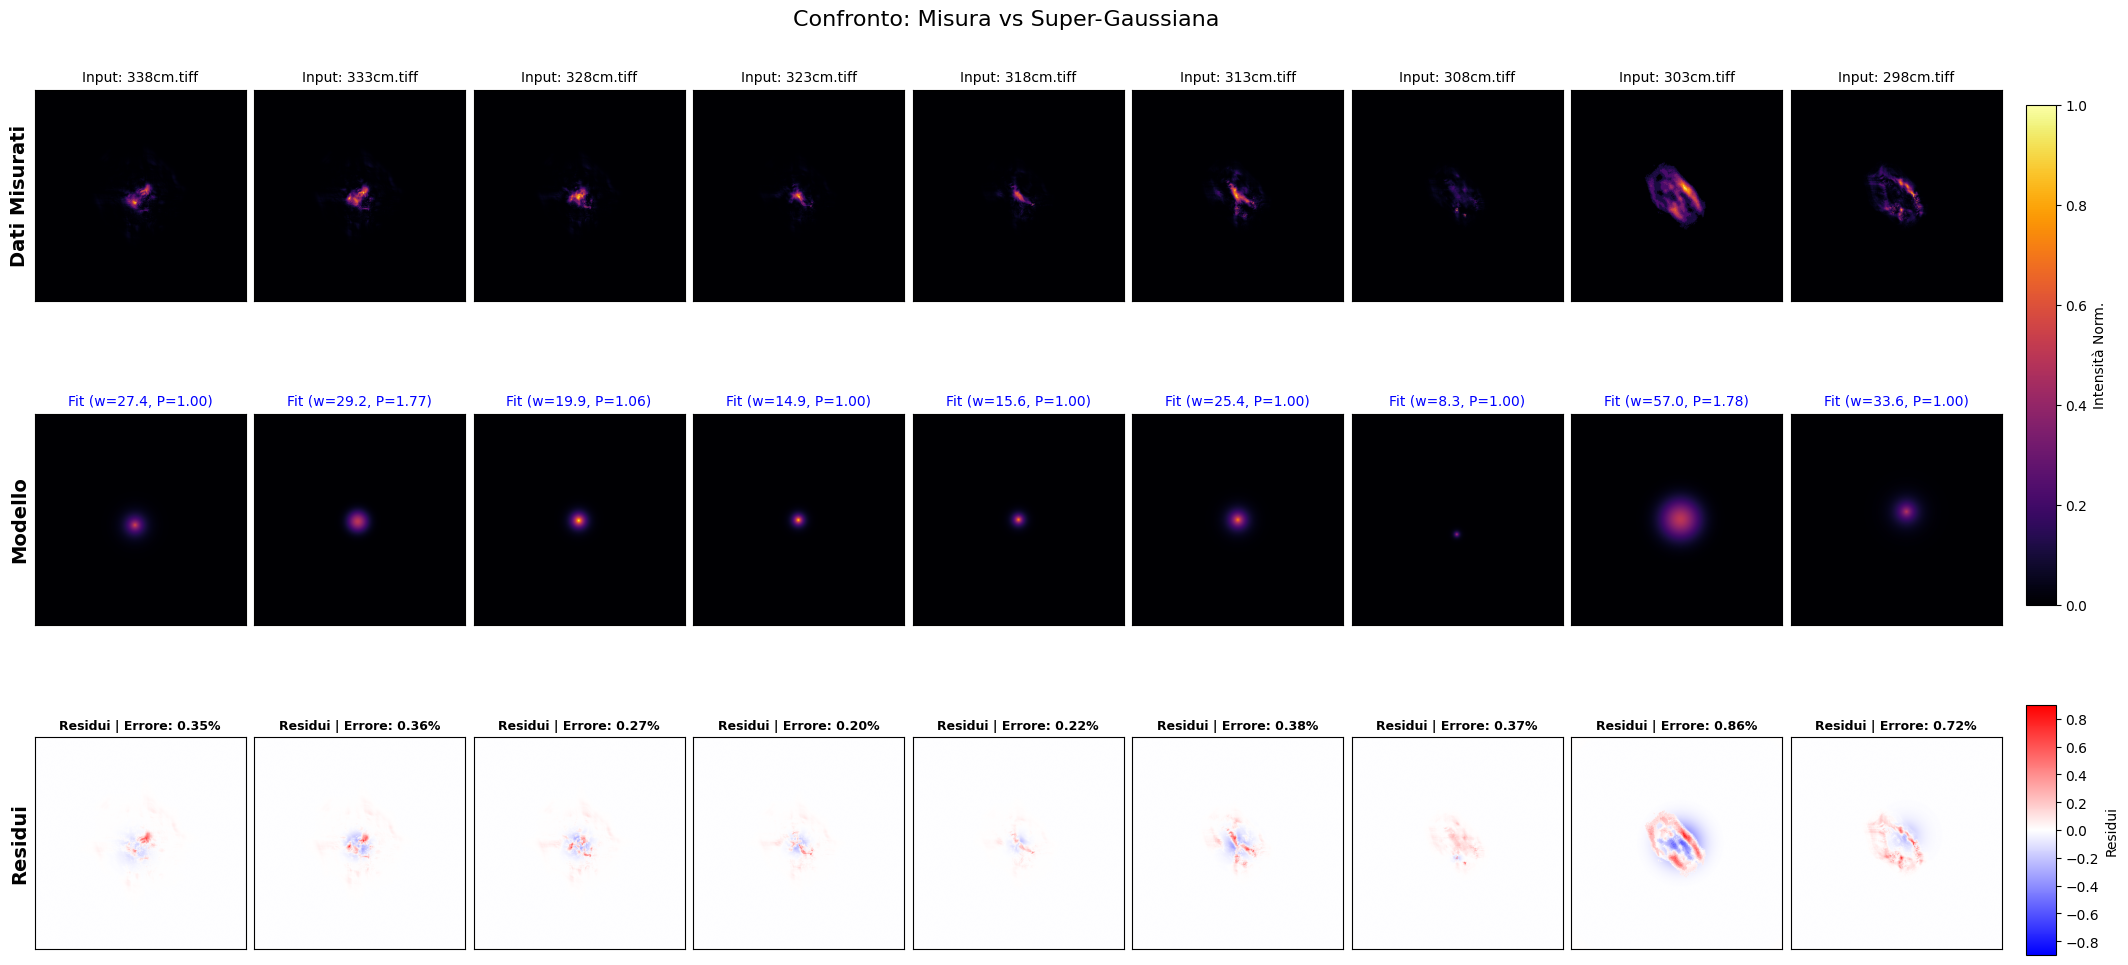

In [19]:

# Create list of keys 3 rows x N columns
n_imgs = len(normalized_input_intensity)

row_meas = [f"meas_{i}" for i in range(n_imgs)]  # ['meas_0', 'meas_1', ...]
row_fit  = [f"fit_{i}"  for i in range(n_imgs)]  # ['fit_0', 'fit_1', ...]
row_res  = [f"res_{i}"  for i in range(n_imgs)]  # ['res_0', 'res_1', ...]

layout = [row_meas, row_fit, row_res] # Matrix of string

fig, axd = plt.subplot_mosaic(layout, figsize=(20, 10), constrained_layout=True)

print("Generazione plot con Mosaic...")

#PLOTTING CYCLE 
for i, (I_measured, params, gy, gx) in enumerate(zip(normalized_input_intensity, fit_intensity, Y, X)):
    
    # A. Model reconstruction
    args = (params['Amplitude'], params['Center_X'], params['Center_Y'], 
            params['Waist'], params['P'], params['Offset'])
    I_model = super_gaussian_curve((gy, gx), *args).reshape(gy.shape)
    
    # B. Residual calculation
    residuals = I_measured - I_model #Makes the difference, this allow us to watch only for the Highr order residuals 
    limit = np.max(np.abs(residuals)) 
    
    # --- CALCULATE PIXEL ERROR ---
    pixel_error = np.mean(np.abs(residuals)) * 100
    params['Pixel_Error'] = pixel_error
    # ----------------------------

    # C. Plotting using dictionary keys
    
    # --- Riga 1: measured ---
    key_m = f"meas_{i}"
    im_m = axd[key_m].imshow(I_measured, cmap='inferno', vmin=0, vmax=1)
    axd[key_m].set_title(f"Input: {params['Name']}", fontsize=10)
    
    # --- Riga 2: Fit ---
    key_f = f"fit_{i}"
    im_f = axd[key_f].imshow(I_model, cmap='inferno', vmin=0, vmax=1)
    axd[key_f].set_title(f"Fit (w={params['Waist']:.1f}, P={params['P']:.2f})", fontsize=10, color='blue')
    
    # --- Riga 3: Residual ---
    key_r = f"res_{i}"
    im_r = axd[key_r].imshow(residuals, cmap='bwr', vmin=-limit, vmax=limit)
    axd[key_r].set_title(f"Residui | Errore: {pixel_error:.2f}%", fontsize=9, fontweight='bold')
    
    for key in [key_m, key_f, key_r]:
        axd[key].set_xticks([])
        axd[key].set_yticks([])

# --- 4.Add Colorbar ---
axd["meas_0"].set_ylabel("Dati Misurati", fontsize=14, fontweight='bold')
axd["fit_0"].set_ylabel("Modello", fontsize=14, fontweight='bold')
axd["res_0"].set_ylabel("Residui", fontsize=14, fontweight='bold')


cbar_ax1 = fig.add_axes([1.01, 0.4, 0.015, 0.5]) 
fig.colorbar(im_m, cax=cbar_ax1, label='Intensità Norm.')

cbar_ax2 = fig.add_axes([1.01, 0.05, 0.015, 0.25])
fig.colorbar(im_r, cax=cbar_ax2, label='Residui')

plt.suptitle("Confronto: Misura vs Super-Gaussiana", fontsize=16)
plt.show()

# Crop and Phase Masking

*We want to understand where te ROI is, to do so we take 2*waist dimension to identify the Iris of the beam, here we apply a phase mask and a crop before proceeding in zernike calculation. Also we can calculate a Peak-Valley Ratio which gives us an information on the quality of the Unwrapping:

- $PV< 5 rad$, phase cleaned and ready to be zernike decomposed;
- $PV> 12.5 rad$, could be a residual error in the wrapping process. 

In particular we should avoid multiple of  $\pi $.

Avvio estrazione ROI sulla Fase...


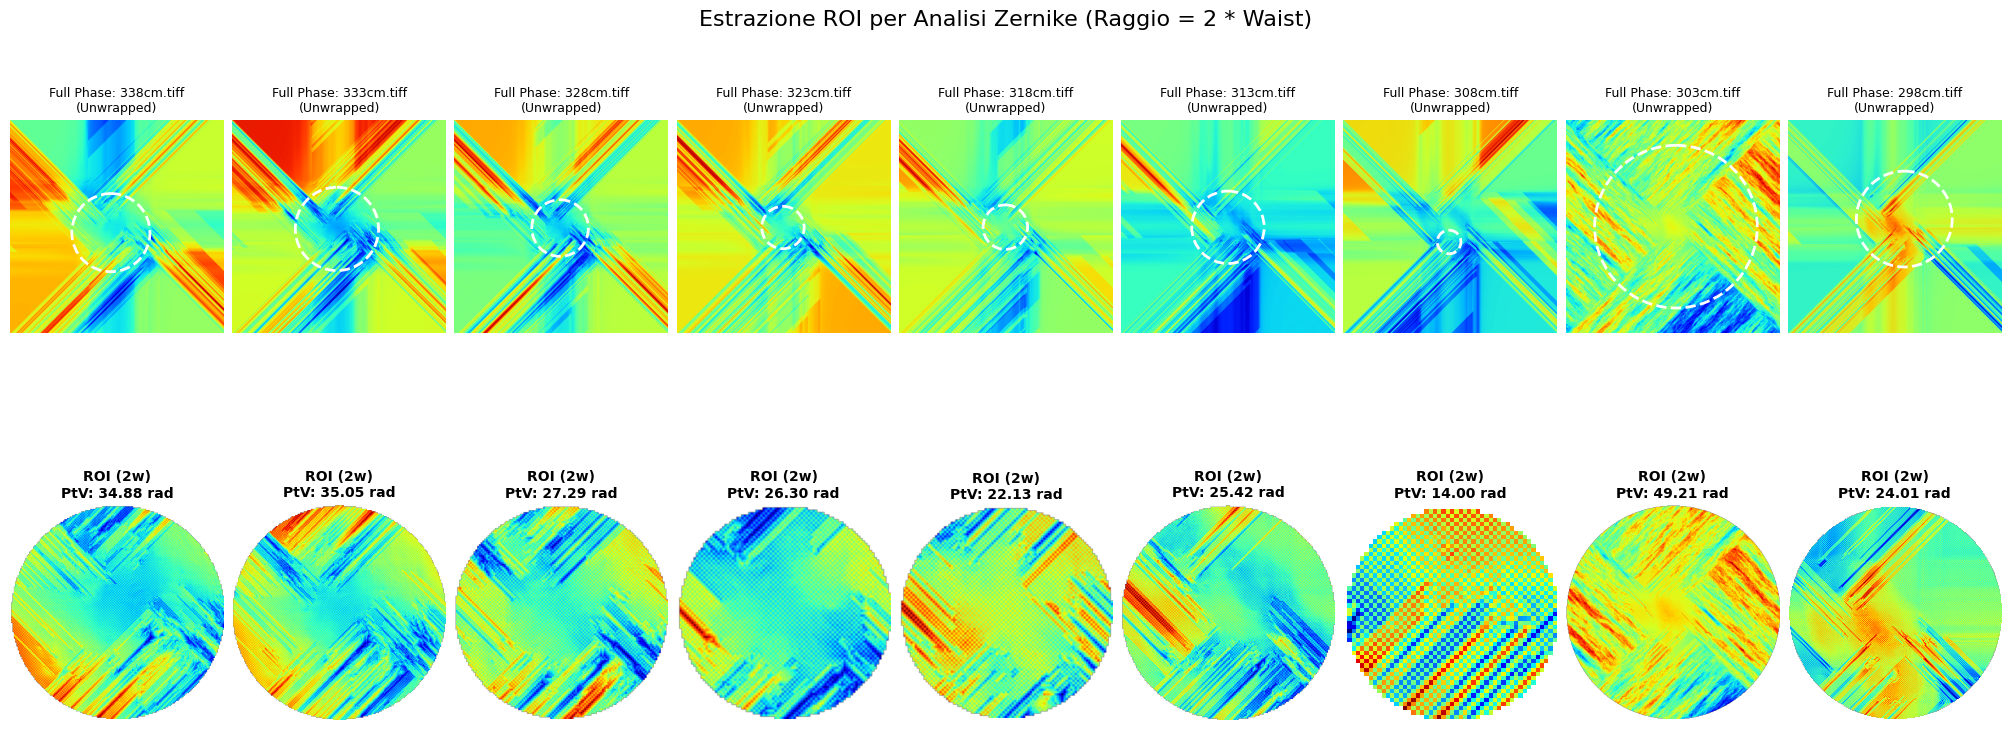

In [ ]:

phases_for_zernike = []

def get_circular_roi(image, cx, cy, radius):
    """
    1. Ritaglia un quadrato attorno al centro (Crop).
    2. Applica una maschera circolare (NaN fuori dal raggio).
    """
    h, w = image.shape
    
    #1. square limit definition, prevent the code from going out of bounds. Ceil and floor prevent outer pixel cutoff
    x1 = int(np.floor(max(0, cx - radius)))
    x2 = int(np.ceil(min(w, cx + radius)))
    y1 = int(np.floor(max(0, cy - radius)))
    y2 = int(np.ceil(min(h, cy + radius)))
    
    cropped_square = image[y1:y2, x1:x2].copy()
    
    #2. Create circular mask
    h_c, w_c = cropped_square.shape
    Y, X = np.ogrid[:h_c, :w_c]
    
    #center the cropped image
    local_cx = cx - x1
    local_cy = cy - y1
    
    dist_sq = (X - local_cx)**2 + (Y - local_cy)**2
    #set to NaN all the value outside the iris
    #mask = dist_sq > radius**2
    #cropped_square[mask] = np.nan
    cropped_square = np.ma.masked_where(dist_sq>radius**2,cropped_square)
    #Calculate Peak to valley
    if np.all(np.isnan(cropped_square)):
        ptv = 0
        piston_value = np.nanmean(cropped_square) # Remove piston from coefficents, we substract med
        cropped = cropped - piston_value
    else:
        ptv = np.nanmax(cropped_square) - np.nanmin(cropped_square)

    return cropped_square, ptv

print("Avvio estrazione ROI sulla Fase...")


n_imgs = len(fit_intensity)
row_raw = [f"raw_{i}" for i in range(n_imgs)]
row_crop = [f"crop_{i}" for i in range(n_imgs)]
fig, axd = plt.subplot_mosaic([row_raw, row_crop], figsize=(20, 8), constrained_layout=True)


for i, params in enumerate(fit_intensity):
    
    # A. Get fit params
    name = params['Name']
    w_fit = params['Waist']
    cx = params['Center_X']
    cy = params['Center_Y']
    
    # B. Calculate ROI, set to 2.0 
    if name == '325mm.tif':
        roi_radius = w_fit * 2.0
    else:
        roi_radius = w_fit * 3.0
    
    # C. Retrieve Unwrap phase 
    raw_phase = GS.RetrievePhase(name, unwrap=True)
    
    # D. Apply ROI
    masked_phase, ptv_value = get_circular_roi(raw_phase, cx, cy, roi_radius)
    
    # Saving 
    phases_for_zernike.append({
        'Name': name,
        'Phase_Data': masked_phase,
        'PtV': ptv_value,
        'Radius_px': roi_radius 
    })
    
    # --- PLOTTING ---
    # 1. Raw phase 
    axd[f"raw_{i}"].imshow(raw_phase, cmap='jet')
    axd[f"raw_{i}"].set_title(f"Full Phase: {name}\n(Unwrapped)", fontsize=9)
    # Draw ROI circle
    circle = plt.Circle((cx, cy), roi_radius, color='white', fill=False, lw=2, ls='--')
    axd[f"raw_{i}"].add_patch(circle)
    axd[f"raw_{i}"].axis('off')

    # 2.Cropped phase
    im = axd[f"crop_{i}"].imshow(masked_phase, cmap='jet')
    axd[f"crop_{i}"].set_title(f"ROI (2w)\nPtV: {ptv_value:.2f} rad", fontsize=10, fontweight='bold')
    axd[f"crop_{i}"].axis('off')

axd["raw_0"].set_ylabel("Fase Totale", fontsize=14, fontweight='bold')
axd["crop_0"].set_ylabel("Crop & Mask", fontsize=14, fontweight='bold')

plt.suptitle("Estrazione ROI per Analisi Zernike (Raggio = 2 * Waist)", fontsize=16)
plt.show()

# Zernike's coefficent

In [21]:
# Funzione Helper per convertire Noll index -> (n, m)
def noll_to_nm(j):
    """
    Converte l'indice sequenziale di Noll (j) nella coppia (n, m).
    Supporta fino ai primi 15 termini (o più se espandi la logica).
    """
    # Indice Noll: (n, m)
    mapping = {
        1: (0, 0),   # Piston
        2: (1, 1),   # Tilt X
        3: (1, -1),  # Tilt Y
        4: (2, 0),   # Defocus
        5: (2, -2),  # Astigmatism 1st
        6: (2, 2),   # Astigmatism 2nd
        7: (3, -1),  # Coma X
        8: (3, 1),   # Coma Y
        9: (3, -3),  # Trefoil X
        10: (3, 3),  # Trefoil Y
        11: (4, 0),  # Spherical
        12: (4, 2),  # Secondary Astig
        13: (4, -2), # Secondary Astig
        14: (4, 4),  # Quadrafoil
        15: (4, -4)  # Quadrafoil
    }
    
    if j in mapping:
        return mapping[j]
    else:
        raise ValueError(f"Indice j={j} non mappato (estendi il dizionario o usa algoritmo completo)")

#-------------------------------------------------------------------------------

zernike_results = []
n_terms = 15 

print(f"Avvio decomposizione Zernike su {len(phases_for_zernike)} piani...")

for item in phases_for_zernike:
    name = item['Name']
    phase_data = item['Phase_Data'] 
    R_pupil = item['Radius_px'] 
    
    # 1. Coordinate setup
    h, w = phase_data.shape
    y, x = np.indices((h, w))
    cy, cx = h // 2, w // 2
    
    r_pixel = np.sqrt((x - cx)**2 + (y - cy)**2)
    theta = np.arctan2(y - cy, x - cx)
    rho = r_pixel / R_pupil 
    
    # 2. Masking
    valid_mask = (~np.isnan(phase_data)) & (rho <= 1.0)
    
    phi_vec = phase_data[valid_mask]
    rho_vec = rho[valid_mask]
    theta_vec = theta[valid_mask]
    
    if len(phi_vec) == 0:
        print(f"Attenzione: Nessun pixel valido per {name}")
        continue

    # 3. Create Zernike Matrix
    matrix_Z = []
    for j in range(1, n_terms + 1):
        # FIX: Converti j -> (n, m)
        n, m = noll_to_nm(j)
        
        # Ora chiami la funzione passando n, m separatamente
        Z_j = zernike.zernike(n, m, rho=rho_vec, theta=theta_vec)
        matrix_Z.append(Z_j)
    
    matrix_Z = np.array(matrix_Z).T
    
    # 4. Solve Least Squares
    coeffs, _, _, _ = np.linalg.lstsq(matrix_Z, phi_vec, rcond=None)
    
    zernike_results.append({
        'Name': name,
        'Coeffs': coeffs,
        'Radius_Used': R_pupil
    })
    
    # Nota: coeffs è base-0, quindi j=4 (Defocus) è all'indice 3
    # j=5 (Astig 1) è indice 4, j=6 (Astig 2) è indice 5
    defocus = coeffs[3]
    astigmatism = np.sqrt(coeffs[4]**2 + coeffs[5]**2)
    
    print(f"{name:<20} | Defocus (Z4): {defocus:.4f} | Astig (Z5+Z6): {astigmatism:.4f}")

print("Calcolo completato.")

Avvio decomposizione Zernike su 9 piani...
338cm.tiff           | Defocus (Z4): 1.3007 | Astig (Z5+Z6): 1.6491
333cm.tiff           | Defocus (Z4): 1.9649 | Astig (Z5+Z6): 1.7163
328cm.tiff           | Defocus (Z4): 0.7776 | Astig (Z5+Z6): 1.1411
323cm.tiff           | Defocus (Z4): 0.0697 | Astig (Z5+Z6): 2.2848
318cm.tiff           | Defocus (Z4): -0.4513 | Astig (Z5+Z6): 1.4179
313cm.tiff           | Defocus (Z4): 0.2800 | Astig (Z5+Z6): 0.9044
308cm.tiff           | Defocus (Z4): 0.0788 | Astig (Z5+Z6): 0.8282
303cm.tiff           | Defocus (Z4): -0.6299 | Astig (Z5+Z6): 2.1822
298cm.tiff           | Defocus (Z4): -1.3839 | Astig (Z5+Z6): 0.4970
Calcolo completato.


# Reconstruction with Zernike coefficents

We use the recently obtained coeffs value to reconstruct the phase diagram.

Inizio ricostruzione della fase dai coefficienti...


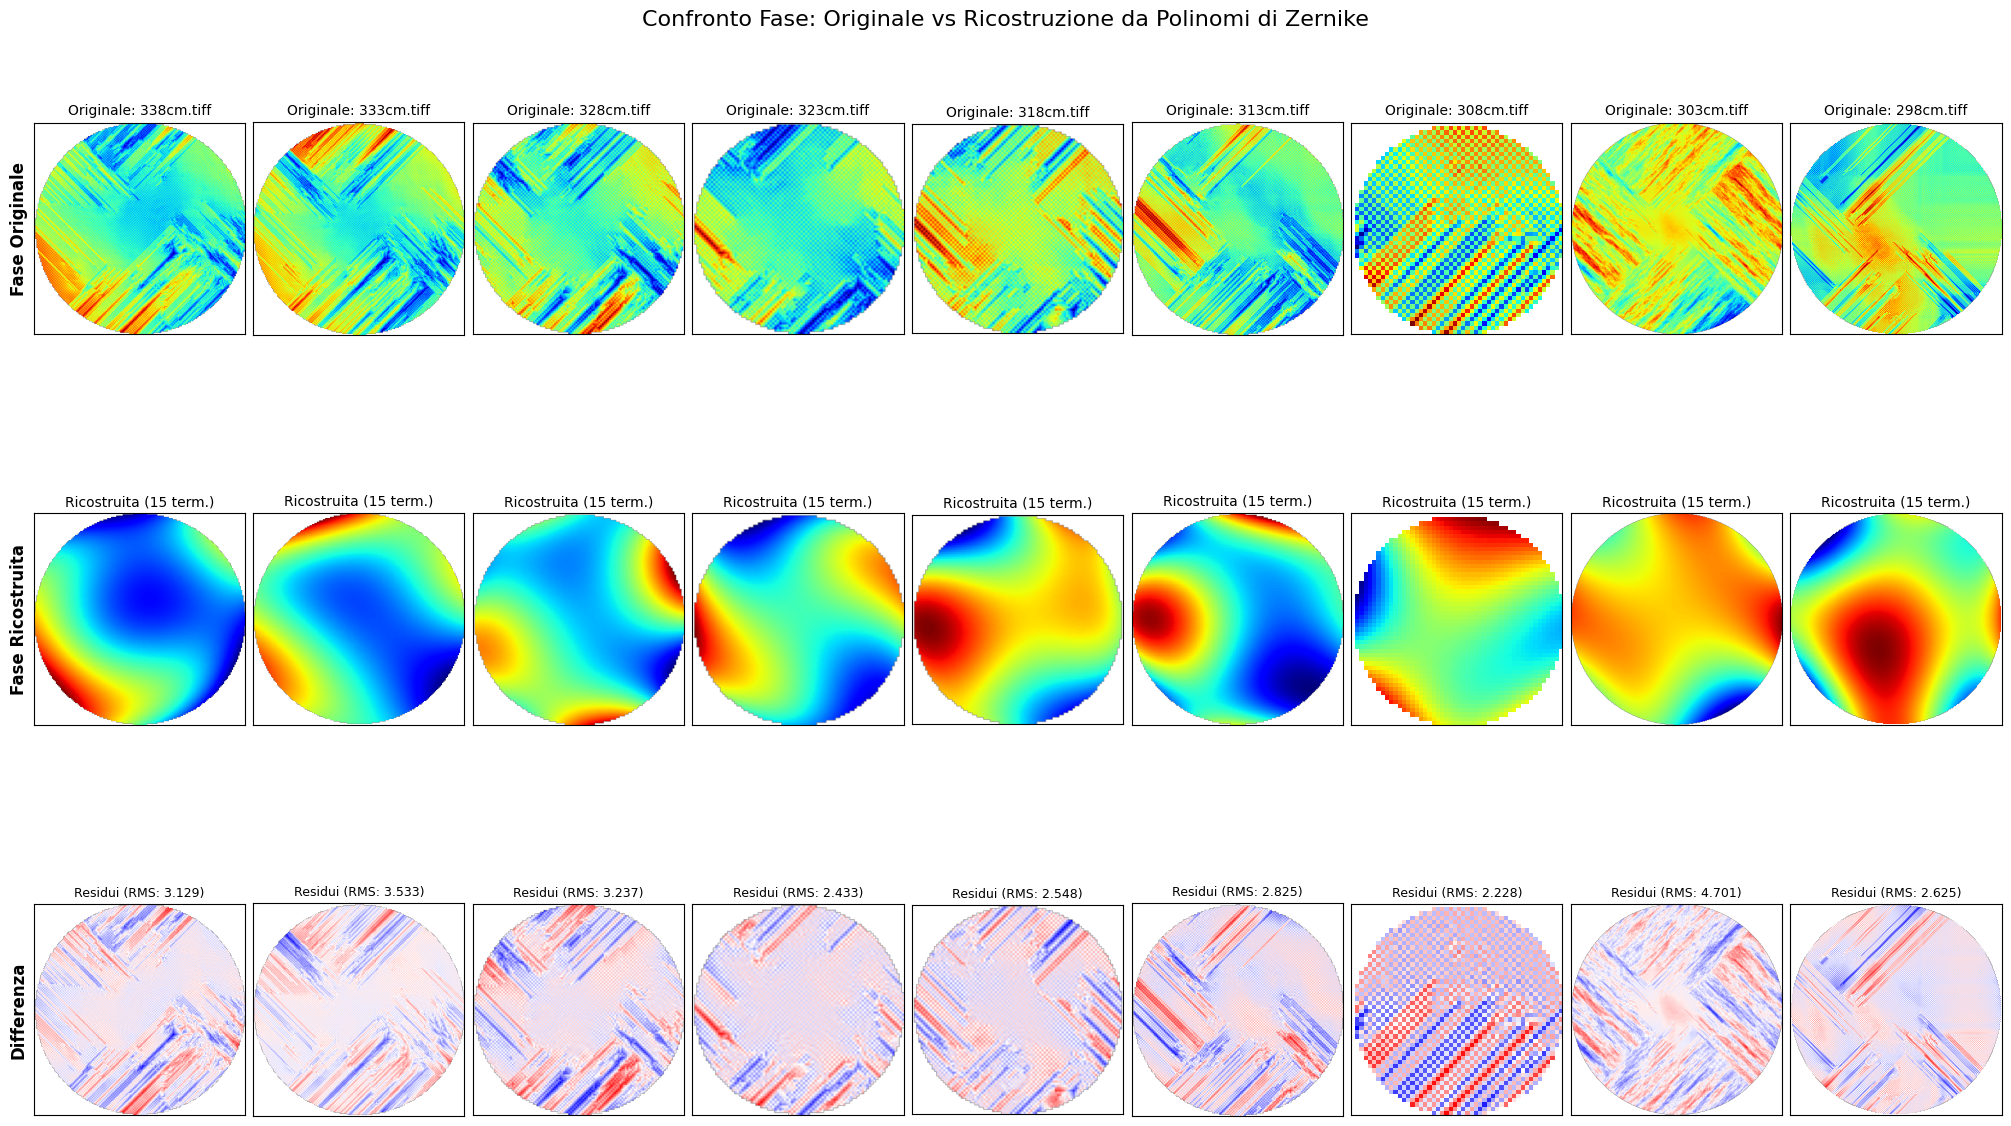

In [22]:
pre_zernike_phase = copy.deepcopy(phases_for_zernike)

# Config. mosaic
n_imgs = len(zernike_results)
row_orig = [f"orig_{i}" for i in range(n_imgs)]
row_recon = [f"recon_{i}" for i in range(n_imgs)]
row_diff = [f"diff_{i}" for i in range(n_imgs)]

layout = [row_orig, row_recon, row_diff]
fig, axd = plt.subplot_mosaic(layout, figsize=(20, 12), constrained_layout=True)

print("Inizio ricostruzione della fase dai coefficienti...")

# Reconstruction and plot
for i, (res, item) in enumerate(zip(zernike_results, pre_zernike_phase)):
    
    # Data retrieve
    name = res['Name']
    coeffs = res['Coeffs']
    R_pupil = res['Radius_Used']
    
    # Attenzione: qui nel loop precedente usavi 'Phase_Data', controlla se 'Phase_Crop' esiste
    # Se 'Phase_Crop' non esiste nel dizionario, usa 'Phase_Data'
    phase_orig = item.get('Phase_Crop', item.get('Phase_Data')) 
    
    # Create coordinate grid
    h, w = phase_orig.shape
    y, x = np.indices((h, w))
    cy, cx = h // 2, w // 2
    rho = np.sqrt((x - cx)**2 + (y - cy)**2) / R_pupil
    theta = np.arctan2(y - cy, x - cx)
    
    pupil_mask = (rho <= 1.0)
    # Initialize reconstructed matrix
    phase_recon_flat = np.zeros(np.sum(pupil_mask))
    
    for j, c_j in enumerate(coeffs):
        # FIX: Conversione da indice j (base 0 del loop) a Noll (j+1) -> (n, m)
        n, m = noll_to_nm(j + 1)
        
        # FIX: Chiamata corretta con n, m
        Z_j = zernike.zernike(n, m, rho=rho[pupil_mask], theta=theta[pupil_mask])
        phase_recon_flat += c_j * Z_j
    
    # Remapping
    phase_recon = np.full((h, w), np.nan)
    phase_recon[pupil_mask] = phase_recon_flat
    
    # Residual error calculated
    diff = phase_orig - phase_recon
    rms_error = np.sqrt(np.nanmean(diff**2))
    
    # --- PLOTTING ---
    
    # Riga 1: Originale
    im0 = axd[f"orig_{i}"].imshow(phase_orig, cmap='jet')
    axd[f"orig_{i}"].set_title(f"Originale: {name}", fontsize=10)
    
    # Riga 2: Ricostruita
    im1 = axd[f"recon_{i}"].imshow(phase_recon, cmap='jet')
    axd[f"recon_{i}"].set_title(f"Ricostruita ({len(coeffs)} term.)", fontsize=10)
    
    # Riga 3: Residui
    limit = np.nanmax(np.abs(diff)) if not np.all(np.isnan(diff)) else 1
    im2 = axd[f"diff_{i}"].imshow(diff, cmap='bwr', vmin=-limit, vmax=limit)
    axd[f"diff_{i}"].set_title(f"Residui (RMS: {rms_error:.3f})", fontsize=9)
    
    for row in [f"orig_{i}", f"recon_{i}", f"diff_{i}"]:
        axd[row].set_xticks([])
        axd[row].set_yticks([])

# Labels finali
if n_imgs > 0:
    axd["orig_0"].set_ylabel("Fase Originale", fontsize=12, fontweight='bold')
    axd["recon_0"].set_ylabel("Fase Ricostruita", fontsize=12, fontweight='bold')
    axd["diff_0"].set_ylabel("Differenza", fontsize=12, fontweight='bold')

plt.suptitle("Confronto Fase: Originale vs Ricostruzione da Polinomi di Zernike", fontsize=16)
plt.show()

# Report Ottico

We present the coefficent variation respect to the image from which they were  obtained.

Avvio calcolo metriche...


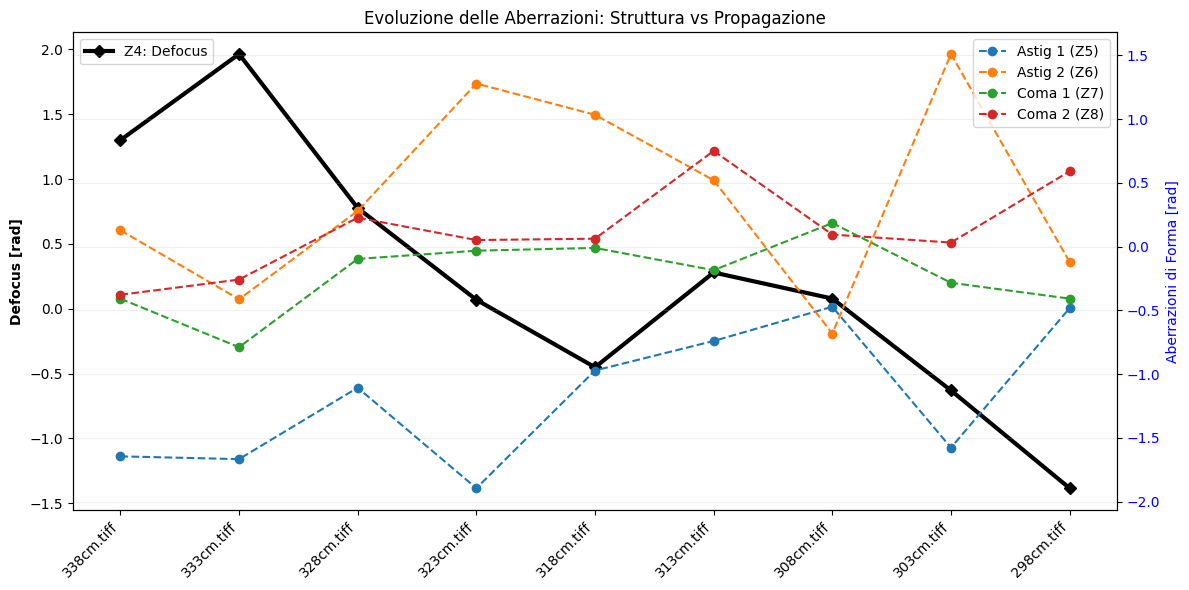

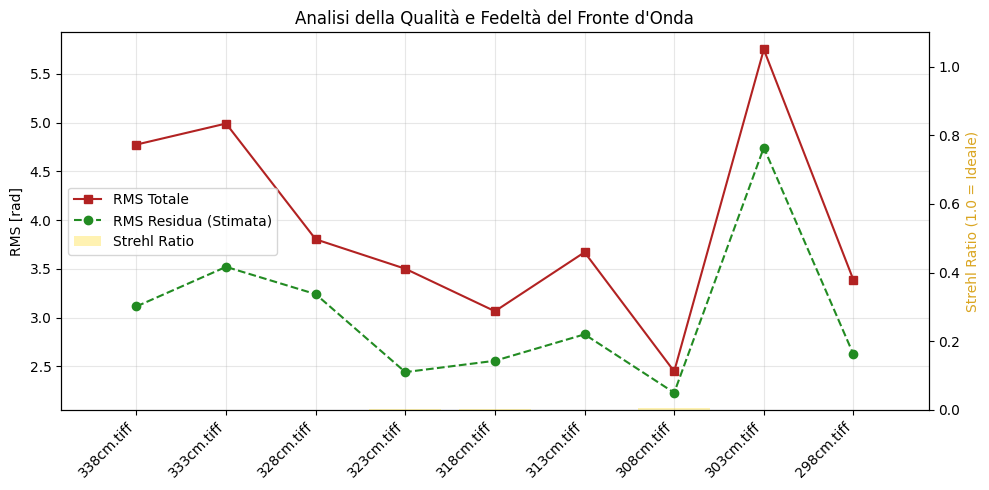

In [23]:
# 1. Recupero Dati e Setup Variabili
names = [res['Name'] for res in zernike_results]
indices = np.arange(len(names))
# Creiamo una matrice (N_immagini x N_coefficienti) per il plot
all_coeffs = np.array([res['Coeffs'] for res in zernike_results])

rms_originale = []
rms_residua = []
strehl_ratio = []

print("Avvio calcolo metriche...")

for res, item in zip(zernike_results, pre_zernike_phase):
    # FIX: Usa .get per cercare 'Phase_Crop', se manca usa 'Phase_Data'
    orig = item.get('Phase_Crop', item.get('Phase_Data'))
    
    if orig is None:
        print(f"Errore: Dati fase non trovati per {res['Name']}")
        continue

    coeffs = res['Coeffs']
    R_pupil = res['Radius_Used']
    
    # RMS Originale (ignora i NaN)
    rms_o = np.nanstd(orig) 
    rms_originale.append(rms_o)
    
    # RMS Residua
    # Nota: Se non hai salvato 'RMS_Residua' nel passaggio precedente, 
    # qui usiamo un valore placeholder o un'approssimazione rapida.
    # Per essere precisi dovresti ricalcolare la differenza come fatto nel plot precedente.
    # Qui usiamo un'approssimazione (RMS_res^2 ≈ RMS_tot^2 - sum(Coeffs^2))
    # Escludendo il pistone (coeffs[0]) se presente.
    power_zernike = np.sum(coeffs[1:]**2) if len(coeffs) > 1 else 0
    estimated_variance = max(0, rms_o**2 - power_zernike) # Evita radici negative
    rms_r = np.sqrt(estimated_variance)
    
    # Oppure usa il tuo placeholder se preferisci:
    # rms_r = res.get('RMS_Residua', 0.1) 
    
    rms_residua.append(rms_r)
    
    # Calcolo Strehl (Approssimazione di Maréchal)
    strehl = np.exp(-(rms_r**2))
    strehl_ratio.append(strehl)

# --- PLOTTING ---

# 1. Evoluzione delle Aberrazioni
fig, ax1 = plt.subplots(figsize=(12, 6))

# Asse per il Defocus (Z4 - Indice 3)
ax1.plot(indices, all_coeffs[:, 3], 'D-', color='black', label="Z4: Defocus", lw=3)
ax1.set_ylabel("Defocus [rad]", fontweight='bold')
ax1.tick_params(axis='y')

# Asse secondario per Astigmatismo e Coma
ax2 = ax1.twinx()
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
labels = ["Astig 1 (Z5)", "Astig 2 (Z6)", "Coma 1 (Z7)", "Coma 2 (Z8)"]

# Loop corretto sugli indici (da 4 a 7 per prendere Z5, Z6, Z7, Z8)
# Assicurati che all_coeffs abbia abbastanza colonne!
for j, col, lab in zip(range(4, 8), colors, labels):
    if j < all_coeffs.shape[1]:
        ax2.plot(indices, all_coeffs[:, j], 'o--', color=col, label=lab)

ax2.set_ylabel("Aberrazioni di Forma [rad]", color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

plt.title("Evoluzione delle Aberrazioni: Struttura vs Propagazione")
ax1.set_xticks(indices)
ax1.set_xticklabels(names, rotation=45, ha='right')
# Combinare le legende è tricky con twinx, usiamo posizioni fisse
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

# 2. Quality Graph
fig, ax_rms = plt.subplots(figsize=(10, 5))

ax_rms.plot(indices, rms_originale, 's-', color='firebrick', label='RMS Totale')
ax_rms.plot(indices, rms_residua, 'o--', color='forestgreen', label='RMS Residua (Stimata)')
ax_rms.set_ylabel("RMS [rad]")
ax_rms.grid(True, alpha=0.3)

# Asse secondario Strehl
ax_s = ax_rms.twinx()
ax_s.bar(indices, strehl_ratio, alpha=0.3, color='gold', label='Strehl Ratio')
ax_s.set_ylim(0, 1.1)
ax_s.set_ylabel("Strehl Ratio (1.0 = Ideale)", color='goldenrod')

plt.title("Analisi della Qualità e Fedeltà del Fronte d'Onda")
ax_rms.set_xticks(indices)
ax_rms.set_xticklabels(names, rotation=45, ha='right')

# Legenda unificata "a mano"
lines, labels = ax_rms.get_legend_handles_labels()
lines2, labels2 = ax_s.get_legend_handles_labels()
ax_rms.legend(lines + lines2, labels + labels2, loc='center left')

plt.tight_layout()
plt.show()